# Settings

In [1]:
# Imports

#%autoreload 2
import sqlite3 as lite
import pandas as pd
import numpy as np
import geopandas as gpd
import sys
sys.path.append('/warehouse/COMPLEXNET/jlevyabi/network_representation/python_scripts/')
import helpers_ses_prediction as hsp
from tqdm import tqdm
import pickle
from tqdm import tqdm_notebook as tqdmn
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as tkr
import pandas as pd
import numpy as np
import geopandas as gpd
from datetime import datetime
from collections import Counter
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
from scipy.spatial import cKDTree
from collections import Counter
#from geopy.distance import vincentys
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

#Plotting environment
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
plt.style.use('bmh')

Import of gensim commented. Remove when needed


/home/jlevyabi/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<a id='home_anchor'></a>
# Home Inference for SES users

In [2]:
import pickle
dic_final_not_nan=pickle.load(open(
    "/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/all_together_dic.p","rb"))
dic_iris_not_nan=pickle.load(open(
    "/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/all_together_dic_iris.p","rb"))

Load [home selection functions](#home_selection)

In [4]:
home_most_freq_all=go_through_home_candidates(dic_final_not_nan,take_most_frequent)
home_most_freq_night=go_through_home_candidates(dic_final_not_nan,take_most_frequent_night)

home_most_freq_all_iris=go_through_home_candidates(dic_iris_not_nan,take_most_frequent)
home_most_freq_night_iris=go_through_home_candidates(dic_iris_not_nan,take_most_frequent_night)
%clear

In [5]:
print("Number of geolocated users INSEE(most freq) ... %d"%len(home_most_freq_all))
print("Number of geolocated users INSEE(most freq night) ... %d"%len(home_most_freq_night))
print("Number of geolocated users IRIS(most freq) ... %d"%len(home_most_freq_all_iris))
print("Number of geolocated users INSEE(most freq night) ... %d"%len(home_most_freq_night_iris))
print("Number of geolocated users with INSEE and IRIS info ...%d"%
      len(set(list(dic_final_not_nan.keys())).intersection(set(list(dic_iris_not_nan.keys())))))

Number of geolocated users INSEE(most freq) ... 28397
Number of geolocated users INSEE(most freq night) ... 24032
Number of geolocated users IRIS(most freq) ... 24109
Number of geolocated users INSEE(most freq night) ... 17588
Number of geolocated users with INSEE and IRIS info ...24109


## User to Income DataFrames for INSEE and IRIS

In [6]:
usr2insee=pd.DataFrame([x.values for x in home_most_freq_all.values()],
                       columns=(list(home_most_freq_all.values())[0]).keys())

usr2insee["poor_men"]=(usr2insee.men_prop/usr2insee.men)

usr2iris=pd.DataFrame([x.values for x in home_most_freq_all_iris.values()],
                      columns=(list(home_most_freq_all_iris.values())[0]).keys())

In [7]:
usr2ses=pd.merge(usr2iris,usr2insee,on="usr")

## Download data from geolocated users 
Data downloaded from users with geolocations with __INSEE information__ (as also contains set of users with __IRIS dataset__)<br>

__Geolocated users__ selected from: [/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/all_together_dic.p](http://url)<br>
Tweets downloaded according to code in the __appendix__ (also can be found in my PC: [/Users/jacobolevyabitbol/Desktop/PhDMarton/projects/ses_inference_linguistic/python_scripts/get_tweets_from_geolocated_users.py](http://url))

_Clean downloaded tweets, remove retweets and merge all individual tweet files_
[/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/merge_geolocated_tweets.py](http://url)<br>

__Final file__ here: [/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/tweets/all_geolocated_users.csv](http://url)

<a id='text_anchor'></a>
# Generate Textual Features

## Profile n-grams

In [8]:
import pickle
import unidecode,re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

#Bio text data
f_accounts="/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/all_together_profiles.p"
f_deleted="/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/all_together_profiles_deleted_accounts.p"
dic_bio=pickle.load(open(f_accounts,"rb"))
dic_bio_deleted=pickle.load(open(f_deleted,"rb"))

#N-Gram vectorizer
french_stopwords = list(set(stopwords.words('french')))
eng_stopwords = list(set(stopwords.words('english')))
n_grams_bio_vect=CountVectorizer(stop_words=french_stopwords+eng_stopwords,
                                 max_features=450,ngram_range=(1,2),
                                lowercase=True)
#Clean profile info
tweet_clean = lambda x:' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",
                                       unidecode.unidecode(x.replace("_",""))).split())

#Generate profile info dataframe
cols_of_interest=["id","followers_count","friends_count",
                         "listed_count","favourites_count","statuses_count","description"]
profile_data=[[usr[0]._json[k] for k in cols_of_interest] for usr in dic_bio ]
df_profile_data=pd.DataFrame(profile_data,columns=cols_of_interest)
df_profile_data["description"]=df_profile_data.description.apply(tweet_clean)
n_grams_bio=n_grams_bio_vect.fit_transform(list(df_profile_data.description.values))


In [1]:
import pickle
usrs_with_SES_info_dic=pickle.load(open("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/usrs_with_SES_info_dic.p","rb"))

In [7]:
from tqdm import tqdm_notebook as tqdmn
%pdb off
inter={}
for k,v in tqdmn(usrs_with_SES_info_dic.items()):
    v=v.rename(index=str, columns={"min": "minu","nb urls":"text"})
    inter[k]=v[["id","time","lat","lon",'geo_pt', 'service', 'profile','text','follows','friends',
                'insee_id', 'idk', 'ind_c', 'men', 'men_surf', 'men_occ5', 'men_coll', 'men_5ind',
                'men_1ind', 'i_1ind', 'men_prop', 'i_prop', 'men_basr', 'i_basr',
                'ind_r', 'ind_age1', 'ind_age2', 'ind_age3', 'ind_age4', 'ind_age5',
                'ind_age6', 'ind_age7', 'i_age7', 'ind_age8', 'i_age8', 'ind_srf',
                'geometry_poly', 'income', 'owner_ratio', 'density',
                'DEC_D113', 'DEC_D213', 'DEC_D313', 'DEC_D413','DEC_MED13',
                'DEC_D613', 'DEC_D713', 'DEC_D813', 'DEC_D913',
               ]]

usrs_with_SES_info_dic=inter
del inter

Automatic pdb calling has been turned OFF


HBox(children=(IntProgress(value=0, max=127614), HTML(value='')))

In [ ]:
list(usrs_with_SES_info_dic.items())[0]

## Tweets data

**Previous version**<br>
<span style="font-size: 0.8em;"> 
usr_tweet_text=generate_text_data(
    fname="*/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/tweets/tweets_geolocated_users.txt*",
    tab_split=";")<br>
d100=pickle.load(open("*/home/jlevyabi/seacabo/data_files/spec_corrected_clusters_only_pos_entries_100.p*","rb"))<br>
usr_full_text=get_cluster_info(d100,usr_tweet_text);<br>
usr_full_text=usr_full_text.reset_index()<br>
usr_tweet_text=usr_tweet_text.reset_index()<br>
tweets_per_user={}<br>
for it,row in tqdmn(usr_tweet_text.iterrows()):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;tweets_per_user.setdefault(row.id,(row.tweet).count("\n"))<br>
</span>

In [9]:
usr_tweet_text=pd.read_csv(
    "/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/tweets/all_geolocated_users.csv",
    sep=';',header=0,)
usr_text=(usr_tweet_text.dropna(how="any").drop(["tweet_id","tweet_date"],axis=1).groupby(
    'user_id',squeeze=True,)['tweet_text'].apply(lambda x: "%s" % ' '.join(x))).to_frame()
usr_text.reset_index(inplace=True)

### Tweets data : N-Grams

In [10]:
n_grams_tweet_vect=CountVectorizer(stop_words=french_stopwords+eng_stopwords,
                                 max_features=560,ngram_range=(1,1),
                                lowercase=True)

n_grams_tweet=n_grams_tweet_vect.fit_transform(list(usr_text.tweet_text.values))

### Tweets data : Semantical Features

Load [cluster distribution function](#cluster_info)

In [13]:
d100=pickle.load(open("/home/jlevyabi/seacabo/data_files/spec_corrected_clusters_only_pos_entries_100.p","rb"))
usr_text=get_cluster_info(d100,usr_text);

100%|██████████| 20830/20830 [04:41<00:00, 74.12it/s]


In [14]:

usr_text_cfd_viz=pd.DataFrame(np.vstack([np.hstack(sample.as_matrix()).reshape((1,100))
                            for it,sample in (usr_text[["cfd_100",]].iterrows())]),
                             columns=list(dic_topics.values()))

In [ ]:
nb=4
z=usr_text_cfd_viz.iloc[nb].values
tip=z>1e-2
real_z=z[tip]
ind = np.arange(0, real_z.shape[0])
plt.barh(ind,real_z,tick_label=np.array(usr_text_cfd_viz.columns)[tip]);
#plt.yticks([])
plt.title("User %s"%usr_text.iloc[nb].user_id)
plt.show()

# Inference Algorithms

## Merge profiles and tweets

In [16]:
df_usr_profile_tweets=pd.merge(df_profile_data,usr_text,left_on="id",right_on="user_id")

#Profile Information: Shallow features
mat_shallow_bio=np.vstack([np.hstack(sample.as_matrix()).reshape((1,5))
                            for it,sample in (df_usr_profile_tweets[["followers_count","friends_count",
                                                                     "listed_count",
                                                                     "favourites_count",
                                                                     "statuses_count",]].iterrows())])
#Profile Information: N-grams
n_grams_bio_vect=CountVectorizer(stop_words=french_stopwords+eng_stopwords,
                                 max_features=450,ngram_range=(1,2),
                                lowercase=True)
mat_n_grams_bio=n_grams_bio_vect.fit_transform(list(df_usr_profile_tweets.description.values)).todense()

#Tweet Information: N-grams
n_grams_tweet_vect=CountVectorizer(stop_words=french_stopwords+eng_stopwords,
                                 max_features=560,ngram_range=(1,1),
                                lowercase=True)
mat_n_grams_tweet=n_grams_tweet_vect.fit_transform(list(df_usr_profile_tweets.tweet_text.values)).todense()

#Tweet Information: Topics
mat_topics_tweet=np.vstack([np.hstack(sample.as_matrix()).reshape((1,100))
                            for it,sample in (df_usr_profile_tweets[["cfd_100",]].iterrows())])

# All non-SES info
data_matrix=np.hstack([mat_n_grams_tweet,mat_n_grams_bio,mat_topics_tweet,mat_shallow_bio])

In [17]:
df_usr_profile_tweets["fts"]=[row for row in data_matrix.tolist()]

## Pipeline of algorithms

In [29]:
ses_text_insee=pd.merge(df_usr_profile_tweets,usr2insee,left_on="id",right_on="usr")
ses_text_iris=pd.merge(df_usr_profile_tweets,usr2iris,left_on="id",right_on="usr")
ses_iris_class_try=np.array(ses_text_iris.DEC_D913>np.mean(ses_text_iris.DEC_D913)).astype(np.int)# 2 class

In [ ]:
clf_test=SVC(kernel="linear", C=0.025)
mat_info=np.vstack([np.hstack(sample.as_matrix()).reshape((1,len(ses_text_iris.iloc[0]["fts"])))
                            for it,sample in (ses_text_iris[["fts",]].iterrows())])

X = StandardScaler().fit_transform(mat_info)
X_train, X_test, y_train, y_test = train_test_split(X, ses_iris_class_try, test_size=.1, random_state=42)
clf_test.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report 
print(clf_test.score(X_test, y_test))

In [ ]:
print(classification_report(y_test,clf_test.predict(X_test)))

In [28]:
# No ejecutar !! Los resultados son los mismos que en la imagen de abajo
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    #QuadraticDiscriminantAnalysis()
    ]

mat_info=np.vstack([np.hstack(sample.as_matrix()).reshape((1,len(ses_text_iris.iloc[0]["fts"])))
                            for it,sample in (ses_text_iris[["fts",]].iterrows())])

X = StandardScaler().fit_transform(mat_info)
X_train, X_test, y_train, y_test = train_test_split(X, ses_iris_class_try, test_size=.1, random_state=42)
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print ("2-Classification accuracy for %s:  %f"%(name,score))

2-Classification accuracy for Nearest Neighbors:  0.547839
2-Classification accuracy for Linear SVM:  0.605020


KeyboardInterrupt: 

__To run__:
~/anaconda3/bin/python /datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/ses_text_inference.py 

##### No profile information

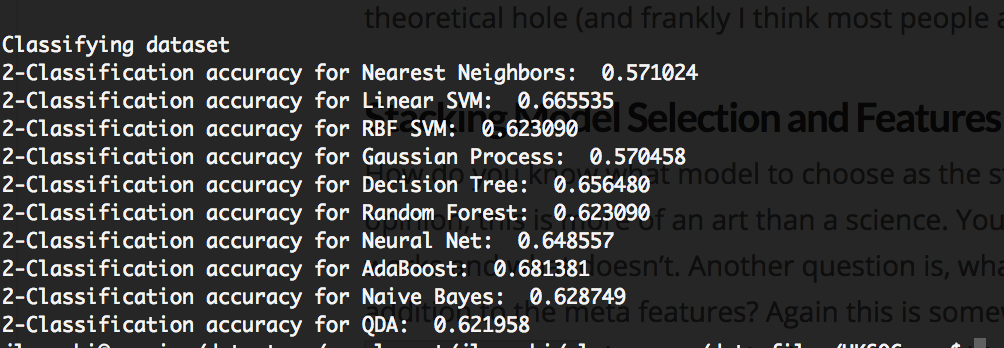

##### With profile information (100 topics )

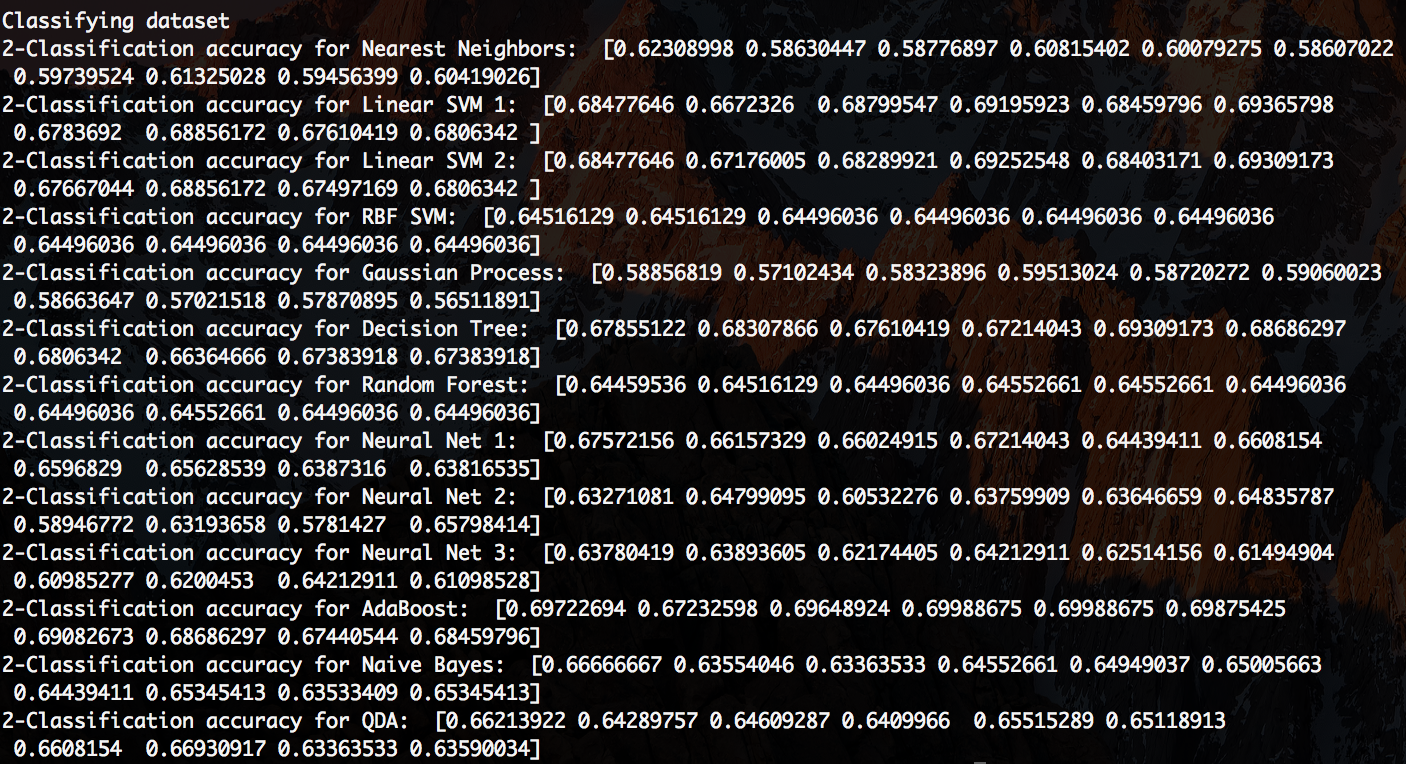

##### With profile information (200 topics - last 6 classifiers)

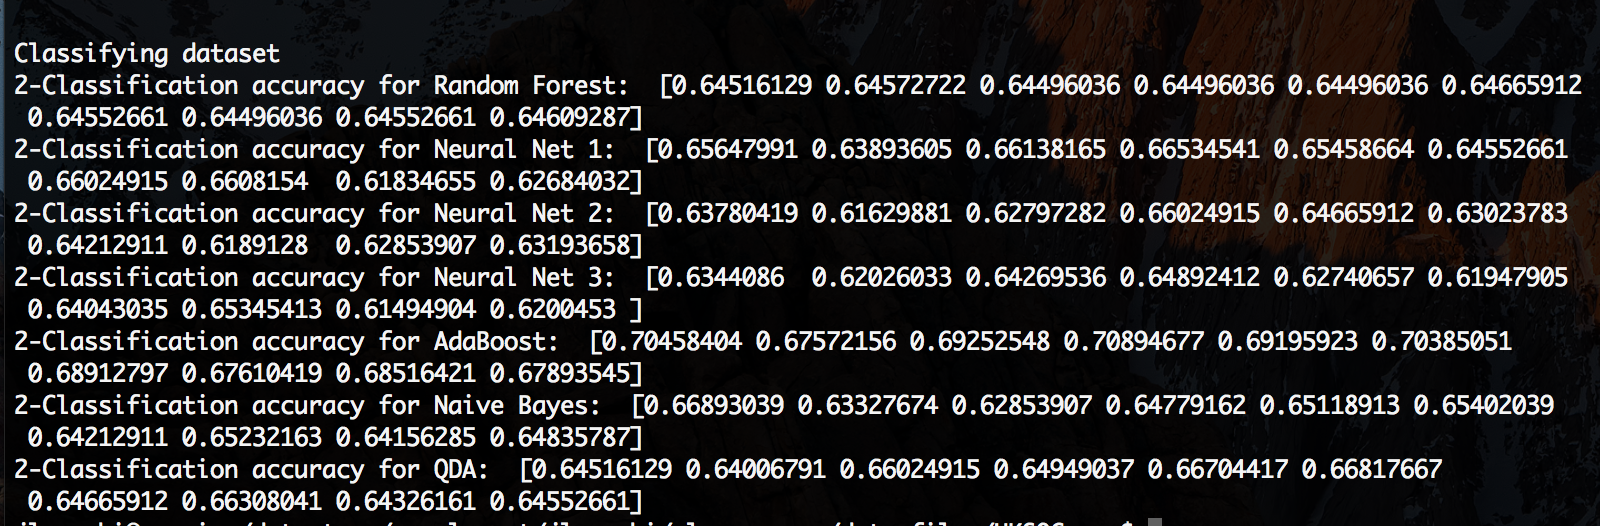

##### With profile information and network (200 topics - last 6 classifiers) 

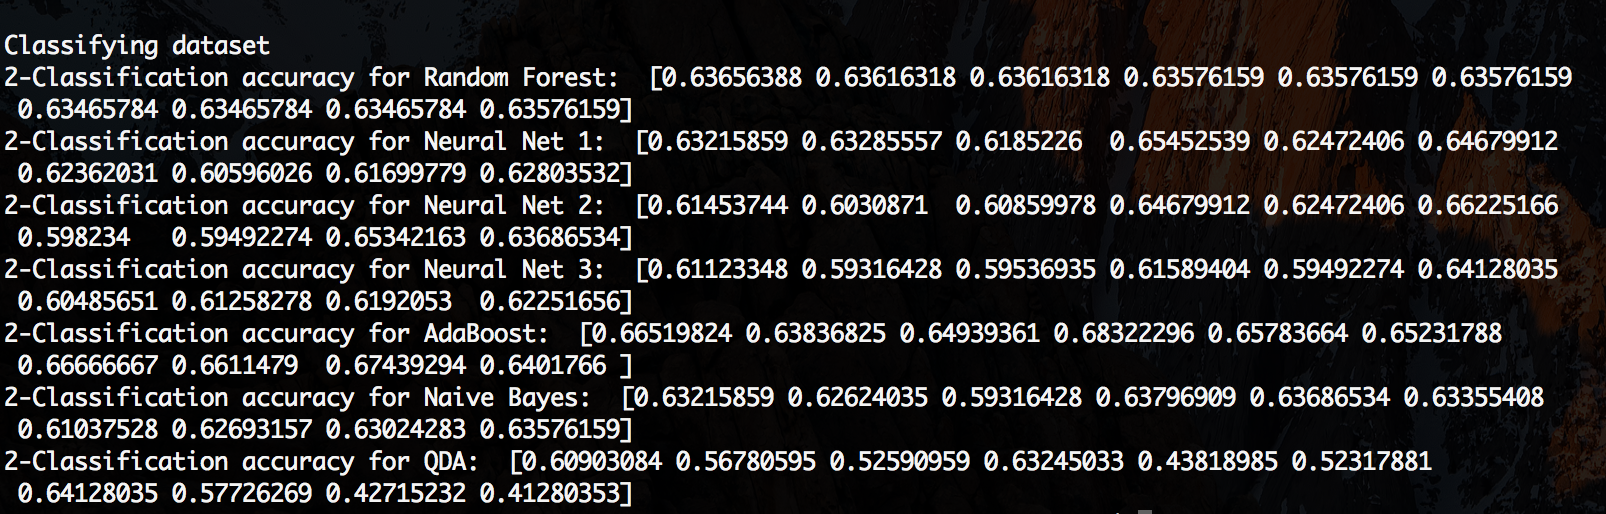

# Appendix

<a id='home_selection'></a>
## Home Selection Algorithms

In [3]:
uk = '+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 \
+x_0=400000 +y_0=-100000 +ellps=airy \
+towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs'
from pyproj import transform,Proj

def proj_arr(points,proj_to):
    inproj = Proj(init='epsg:4326')
    outproj = Proj(proj_to)
    func = lambda x: transform(inproj,outproj,x[1],x[0])
    return np.array(list(map(func, points)))

def take_most_frequent(geopandas_usr):
    polys_visited=list(geopandas_usr.idINSPIRE)
    #time_of_visit=[datetime(row.year,row.month,row.day,row.minu,row.sec) for it,row in geopandas_usr.iterrows()]
    locat_mode=Counter(polys_visited).most_common(1)[0][0]
    idx_mode=polys_visited.index(locat_mode)
    return idx_mode,geopandas_usr.iloc[idx_mode][["lat","lon"]]

def get_check_in_rate_margin_most_freq(geopandas_usr):
    polys_visited=list(geopandas_usr.idINSPIRE)
    inter=Counter(polys_visited).most_common(2)
    if len(inter)<2:
        return None,None,None,None,None
    locat_mode,sec_locat_mode=inter
    idx_mode,idx_mode_sec=polys_visited.index(locat_mode[0]),polys_visited.index(sec_locat_mode[0])
    return (idx_mode,geopandas_usr.iloc[idx_mode][["lat","lon"]],
            idx_mode_sec,geopandas_usr.iloc[idx_mode_sec][["lat","lon"]],
           ((locat_mode[1]+0.0-sec_locat_mode[1])/(sec_locat_mode[1]+locat_mode[1])))

def take_most_frequent_night(geopandas_usr,start=21,stop=6) :
    polys_visited=(geopandas_usr.idINSPIRE)
    polys_visited_night=polys_visited[(geopandas_usr.hour>=start)|(geopandas_usr.hour<stop)]
    if len(polys_visited_night)==0:
        return None,None
    locat_mode=Counter(polys_visited_night).most_common(1)[0][0]
    idx_mode=list(polys_visited).index(locat_mode)
    return idx_mode,geopandas_usr.iloc[idx_mode][["lat","lon"]]

def get_distance_matrix(geopandas_usr):
    x = np.array(geopandas_usr[["lat","lon"]]).astype(float).tolist()
    y=proj_arr(x,uk)
    ztree = cKDTree(y)
    z = ztree.sparse_distance_matrix(ztree,1e6,p=2).todense()
    return z

def distance_to_home(geopandas_usr,select_home_loc,args):
    idx,loc=select_home_loc(geopandas_usr,*args)
    if idx is None:
        return None,None,None
    mat_dist=get_distance_matrix(geopandas_usr)
    return mat_dist[idx,:].tolist()[0],list(geopandas_usr.day),list(geopandas_usr.hour)

def go_through_home_candidates(dic_gpd,select_home_loc):
    dic_exam={}
    for usr,gpd in (dic_gpd.items()):
        idx,loc=select_home_loc(gpd)
        if idx is None:
            continue
        dic_exam.setdefault(usr,gpd.iloc[idx])
    return dic_exam

def go_through_geol_users(dic_gpd,select_home_loc,args,outlier_lim=6e4):
    dic_per_day={k:np.zeros(24) for k in range(7)}
    dic_nb_per_day={k:np.zeros(24) for k in range(7)}
    dic_exam={}
    loss=[]
    for usr,gpd in (dic_gpd.items()):
        dic_exam.setdefault(usr,[])
        dists,days,hours=distance_to_home(gpd,select_home_loc,args)
        new_dists=np.array(dists)
        if dists is None:
            continue
        loss.append(1-(np.sum([new_dists<outlier_lim])+0.0)/len(dists) )
        dists=new_dists[new_dists<outlier_lim]
        for dist,day,hour in zip(dists,days,hours):
            dic_exam[usr].append(dist)
            dic_per_day[day][hour]+=dist
            dic_nb_per_day[day][hour]+=1
    dic_day={}
    for k,v in dic_per_day.items():
        dic_day[k]=(v/dic_nb_per_day[k])/100
    return dic_day,dic_exam,loss

Go [back](#home_anchor)
## Distance to Home (_Not needed_)

/home/jlevyabi/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


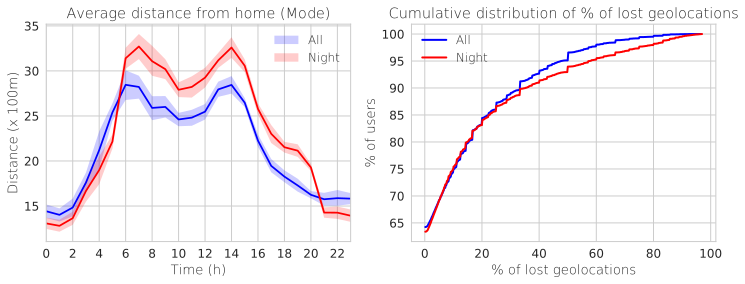

In [5]:
import numpy as np
dic_most_freq,check_all,loss_all=go_through_geol_users(dic_final_not_nan,take_most_frequent,"")
dic_most_freq_night,check_night,loss_night=go_through_geol_users(dic_final_not_nan,take_most_frequent_night,"")

import seaborn as sns
plt.figure(figsize=(12,4))

sns.set(style='whitegrid',font="normal",font_scale=1.2)

sns.plt.subplot(121)
sns.tsplot(list(dic_most_freq.values()),color="b")
sns.tsplot(list(dic_most_freq_night.values()),color="r")
sns.plt.xlabel("Time (h)",weight="light")
sns.plt.ylabel("Distance (x 100m)",weight="light")
sns.plt.title("Average distance from home (Mode)",weight="light")
sns.plt.xticks(range(0,24,2))
sns.plt.legend(["All","Night"],prop={"weight":"light"})

sns.plt.subplot(122)
H_all,X1_all = np.histogram(loss_all, bins = 500, normed = True )
dx_all = X1_all[1] - X1_all[0]
F1_all = np.cumsum(H_all)*dx_all
H_night,X1_night = np.histogram(loss_night, bins = 500, normed = True )
dx_night = X1_night[1] - X1_night[0]
F1_night= np.cumsum(H_night)*dx_night
plt.plot(X1_all[1:]*100, F1_all*100,color="b",lw=2)
plt.plot(X1_night[1:]*100, F1_night*100,color="r",lw=2)
plt.xlabel("% of lost geolocations",weight="light")
plt.ylabel("% of users",weight="light")
sns.plt.legend(["All","Night"],prop={"weight":"light"})
sns.plt.title("Cumulative distribution of % of lost geolocations",weight="light")

#sns.plt.savefig("/datastore/complexnet/jlevyabi/ml_soc_econ/icdm18/dist_to_home.pdf")
sns.plt.show()

<a id='cluster_info'></a>
## Generate cluster information

In [11]:
def get_cluster_info(dic_clus,df_tweets):
    nb_clusters=len(list(dic_clus.keys()))
    word2cluster_only_pos={word:cluster_nb for cluster_nb,cluster_words in dic_clus.items() for word in cluster_words}
    clust_freq_only_pos=[]
    for tweet in tqdm(df_tweets.tweet_text):
        clust_freq_only_pos.append((Counter([word2cluster_only_pos[word]
                                             for word in tweet.split() if word in word2cluster_only_pos])))
    cfd_only_pos=[{k:(v+0.0)/(sum(dic_count.values()))for k,v in dic_count.items()}
                  for dic_count in clust_freq_only_pos]
    df_tweets["cfd_%d"%nb_clusters]=[np.array(list({clus:(dic_count[clus] if clus in dic_count else 0)
                                    for clus in range(len(dic_clus))}.values())) for dic_count in cfd_only_pos]
    return (df_tweets)

Go [back](#text_anchor)

In [12]:
# d100 topic per cluster information
dic_topics={2:"Music",
4:"Computer Science",
11:"English",
12:"News",
13:"Games",
14:"Verbes gerondif -ant",
15: "Health Medicine",
16: "Verbs infinitive -er,ir",
17: "SportSoccer",
18: "Travels English",
19: "Catalan - Spanish Independence",
20: "News Religion-Violence",
21:"Movies",
23: "Personal Adjectives",
24: "Hashtags",
25: "Substantives",
26: "Verbs 3rd plural",
27: "Work More lower",
28: "Verbs Imparfait",
29: "Adjective Singular Feminine",
30: "Substitantives Soutenus",
31:"Arab",
32:"Turk",
33:"French Old Media ",
34: "Arab Names",
35: "Adjective Plural",
36: "Verbs 3rd singular",
37: "Verbs infinitive -er",
38: "English work",
39: "American English Media Personalities",
40: "Modern Music",
41: "Español",
43: "International News Middle East Centered" ,
44: "News/Political Adjective",
45: "Childish writing" ,
46: "Porn",
47: "French Places",
48: "Non Standard adjectives",
49: "Verbs 1st 2nd Plural",
50: "Soccer Players",
51:"English sport NBA UFC Ligue 1",
52:"Music related" ,
54:"Actresses",
55: "Tech",
56: "Sport Bike Tennis",
57: "Feminine Substantif",
58: "American TV Shows",
59: "Substantif Feminine Soutenu",
60: "English Adverbs",
61:"Verbs 2nd singular",
62:"Clothes",
63:"Africa",
64:"Tourism France",
65: "English Teens",
66: "Anime Teen Media Characters",
67: "French Soccer",
68: "French Politics",
70: "Portuguese Italian",
71:"Food",
72:"Poor Writing French",
74:"Critics Adjective soutenus",
75: "German",
76: "Soccer Hashtags",
78:" French Media",
79: "Poor abbreviations",
81:"Lyceens",
82:"English News",
83:"Poor Onomatopeyas",
85: "Voitures",
86: "Poor Verbs",
90: "Apps Tech",
94:"High Culture",
95: "Transportation",
96: "Arab_other",
97: "Descriptors",
99: "Games_other"}

iti=0
for j in range(100):
    if not(j in dic_topics):
        dic_topics[j]="Sth"+str(iti)
        iti+=1

dic_topics={k:dic_topics[k] for k in range(100)}

## Extend learning to network information

In [38]:
f_embed="/datastore/complexnet/jlevyabi/network_representation/data_files/network_files/embeddings/node2vec.emb"
with open(f_embed, 'r') as f:
    first_line = f.readline()
f.close()
dim_embed=int(first_line.split()[1])
net_cols=["dim_"+str(i) for i in range(dim_embed)]

network_emb=pd.read_csv(sep=" ",skiprows=[0],names=["id"]+net_cols,
    filepath_or_buffer=f_embed,)
usr_embed=np.array(network_emb[net_cols])
network_emb["n2v"]=[line for line in usr_embed]

network_emb=network_emb[["id","n2v"]]


In [39]:
ses_text_n2v_iris=pd.merge(ses_text_iris,network_emb,
                          left_on="usr",right_on="id")
ses_iris_n2v_class_try=np.array(ses_text_n2v_iris.DEC_D913>
                            np.mean(ses_text_n2v_iris.DEC_D913)).astype(np.int)# 2 class

mat_info=np.vstack([np.hstack(sample.as_matrix()).reshape((1,len(ses_text_iris.iloc[0]["fts"])))
                            for it,sample in (ses_text_iris[["fts",]].iterrows())])

In [54]:
inter=[]
for row_1,row_2 in zip(ses_text_n2v_iris.fts,ses_text_n2v_iris.n2v):
    inter.append(np.hstack([np.array(row_1),np.array(row_2)]))

ses_text_n2v_iris["n2v+fts"]=inter

In [56]:
mat_info=np.vstack([np.hstack(sample.as_matrix()).reshape((1,len(ses_text_n2v_iris.iloc[0]["n2v+fts"])))
                            for it,sample in (ses_text_n2v_iris[["n2v+fts",]].iterrows())])

## Correlation of different income sources

In [62]:
nb_menages=usr2ses.men_x
nb_menages_unipers=usr2ses.men_1ind_x
nb_menages_gt5=usr2ses.men_5ind_x
nb_menages_2t5=nb_menages-nb_menages_unipers-nb_menages_gt5

people=usr2ses.ind_r_x
children=usr2ses.ind_age1_x+usr2ses.ind_age2_x+usr2ses.ind_age3_x+usr2ses.ind_age4_x# From 
adults=people-children # SURE
adults_count_as_one=nb_menages_unipers+nb_menages_gt5+nb_menages_2t5 # 1 By menage SURE
adults_count_as_half=adults-adults_count_as_one # SURE

work_force=usr2ses.ind_age6_x-usr2ses.ind_age7_x

income_sum_by_uc=usr2ses.ind_srf_x

uc=0.3*children+ 0.5*adults_count_as_half+adults_count_as_one
x=np.array(income_sum_by_uc*uc)/(nb_menages*work_force)
usr2ses["pot_cor"]=x

In [ ]:
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")


def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(usr2ses[["income_y","pot_cor",
                          "DEC_D113",
                          "DEC_MED13","DEC_D913"]], palette=["red"])
g.map_upper(plt.scatter, s=0.2)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)
g.savefig("/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/corrs.pdf")